# Term Document Matrices, Summarization

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


`!pip install ipypublish
!pip install transformers`

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')  # Add My Drive/<>

# import os
# os.chdir('drive/My Drive')
# os.chdir('Teaching/NLP')

In [3]:
%pylab inline
import pandas as pd
import os
from ipypublish import nb_setup
# %load_ext rpy2.ipython

C:\Users\Behnam\Anaconda3\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Behnam\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
C:\Users\Behnam\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Behnam\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


Populating the interactive namespace from numpy and matplotlib


## Getting SEC Data and Special Dictionaries

`!pip install  wordcloud
!pip install multidict
!pip install qgrid`

In [4]:
#Negative words
df = pd.read_excel('NLP_data/LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='Negative', header=None)
df.columns = ["Neg"]
LM_neg = df.Neg.str.lower().to_list()
#Positive words
df = pd.read_excel('NLP_data/LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='Positive', header=None)
df.columns = ["Pos"]
LM_pos = df.Pos.str.lower().to_list()
#Uncertainty words
df = pd.read_excel('NLP_data/LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='Uncertainty', header=None)
df.columns = ["Unc"]
LM_unc = df.Unc.str.lower().to_list()
#Litigious words
df = pd.read_excel('NLP_data/LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='Litigious', header=None)
df.columns = ["Lit"]
LM_lit = df.Lit.str.lower().to_list()

In [5]:
def finScore(url,poswords,negwords,uncwords,litwords):
    f = requests.get(url)
    text = f.text
    f.close()
    text = BeautifulSoup(text,'html').get_text()    
    text = text.replace('\n',' ').lower()
    text = text.split(' ')
    posmatches = set(text).intersection(set(poswords))
    print(posmatches)
    print(len(posmatches))
    negmatches = set(text).intersection(set(negwords))
    print(negmatches)
    print(len(negmatches))
    uncmatches = set(text).intersection(set(uncwords))
    print(uncmatches)
    print(len(uncmatches))
    litmatches = set(text).intersection(set(litwords))
    print(litmatches)
    print(len(litmatches))
    return posmatches, negmatches, uncmatches, litmatches, text

In [6]:
from wordcloud import WordCloud
import multidict as multidict

import os
import re
from PIL import Image
from os import path

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be", text):
            continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict


def makeImage(text):
    wc = WordCloud(background_color="white", max_words=1000, max_font_size=40, mask=mask)
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    imshow(wc, interpolation="bilinear")
    axis("off")
    show()


# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

In [7]:
#Function to convert ticker into CIK
import re
import requests
from requests import get

def ticker2cik(ticker):
    DEFAULT_TICKERS = ['goog', 'aapl']
    URL = 'http://www.sec.gov/cgi-bin/browse-edgar?CIK={}&Find=Search&owner=exclude&action=getcompany'
    CIK_RE = re.compile(r'.*CIK=(\d{10}).*')
    x = get(URL.format(ticker)).content
    return CIK_RE.findall(str(x))[0]

In [8]:
url = 'https://www.sec.gov/Archives/edgar/cik-lookup-data.txt'

f = requests.get(url)
cik = f.text
cik = cik.splitlines()
f.close()
print('No of companies: ',len(cik))

No of companies:  776322


In [9]:
y = array([[j[:-12],j[-11:-1]] for j in cik]).T
df = pd.DataFrame({'Company_Name': y[0], 'CIK':y[1]})
df

,Company_Name,CIK
0,!J INC,0001438823
1,"#1 A LIFESAFER HOLDINGS, INC.",0001509607
2,#1 ARIZONA DISCOUNT PROPERTIES LLC,0001457512
3,#1 PAINTBALL CORP,0001433777
4,$ LLC,0001427189
...,...,...
776317,ZZIF 2008 INVESTMENT LLC,0001448632
776318,"ZZLL INFORMATION TECHNOLOGY, INC",0001365357
776319,"ZZX, LLC",0001691924
776320,ZZYZX ZZAZX ZZOZX INC,0001184274


In [10]:
import ipywidgets
import qgrid
qgrid_widget = qgrid.show_grid(df, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Get the 10K and score it

In [11]:
ticker = 'AMZN'
cik_number = ticker2cik(ticker) # AAPL:0000320193; AMZN:0001018724; MSFT:0000789019; C1: 0001003952
print('Ticker: ',ticker,' CIK: ',cik_number)

Ticker:  AMZN  CIK:  0001018724


In [12]:
# Get 10K
# https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=320193 (page with all forms)
# cik_number = '0001512733'
cik_no_zeros = cik_number.lstrip('0')
url = ['https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK='+cik_no_zeros+'&type=&dateb=&owner=include&start=0&count=100',
       'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK='+cik_no_zeros+'&type=&dateb=&owner=include&start=100&count=200',
       'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK='+cik_no_zeros+'&type=&dateb=&owner=include&start=200&count=300',
       'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK='+cik_no_zeros+'&type=&dateb=&owner=include&start=300&count=400',
       'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK='+cik_no_zeros+'&type=&dateb=&owner=include&start=400&count=500']

idx = 0
for u in url:
    f = requests.get(u)
    txt = f.text
    f.close()
    idx = txt.find("10-K")
    if idx>0:
        x = txt[idx:(idx+300)]
        x1 = x.find('href')
        x2 = x.find('index.htm')
        url = 'https://www.sec.gov' + x[(x1+6):(x2-1)] + '.txt'
        break

if idx>0:
    print(url)
else:
    print('No 10-K found')

https://www.sec.gov/Archives/edgar/data/1018724/000101872420000004/0001018724-20-000004.txt


In [13]:
# !pip install bs4
from bs4 import BeautifulSoup

#Unique sets of words in the 10-K
poswords = LM_pos
negwords = LM_neg
uncwords = LM_unc
litwords = LM_lit
pos, neg, unc, lit, text = finScore(url,poswords,negwords,uncwords,litwords)

{'improving', 'favorable', 'gain', 'profitability', 'greater', 'alliances', 'honoring', 'enhanced', 'good', 'improve', 'gains', 'efficiency', 'best', 'progress', 'stability', 'advantage', 'able', 'easily', 'beneficial', 'achieving', 'attractive', 'effective', 'collaboration', 'enhancements', 'innovative', 'strengthens', 'satisfaction', 'efficiently', 'highest', 'leadership', 'achievement', 'advantages', 'integrity', 'advances', 'enable', 'enhancement', 'efficient', 'succeeding', 'attractiveness', 'complimentary', 'profitable', 'adequately', 'popular', 'strengthen', 'positively', 'efficiencies', 'enhance', 'improvements', 'superior', 'enabled', 'success', 'better', 'satisfying', 'enhancing', 'successfully', 'despite', 'opportunities', 'enhances', 'benefit', 'satisfy', 'successful', 'gained'}
62
{'losses', 'disrupt', 'recalls', 'restatement', 'damaging', 'penalties', 'error', 'unqualified', 'defend', 'weakening', 'impairment', 'disclose', 'unable', 'forced', 'litigation', 'harmed', 'diff

In [14]:
pos = [j for j in text if j in poswords]  
print('Number of positives: ',len(pos))
neg = [j for j in text if j in negwords]
print('Number of negatives: ',len(neg))
unc = [j for j in text if j in uncwords]
print('Number of uncertains: ',len(unc))
lit = [j for j in text if j in litwords]
print('Number of litigious: ',len(lit))

Number of positives:  611
Number of negatives:  1646
Number of uncertains:  1300
Number of litigious:  1718


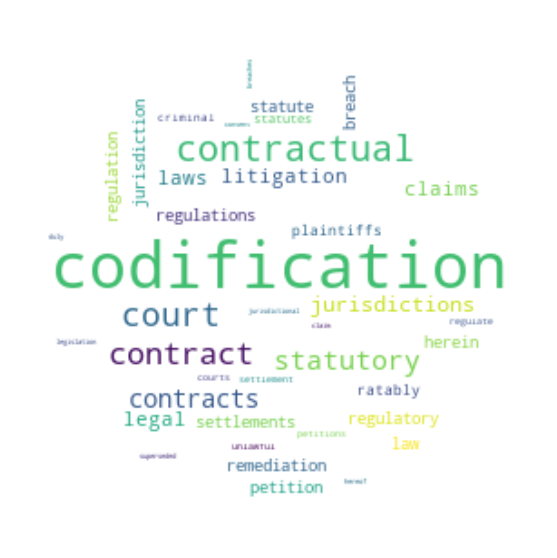

In [15]:
figure(figsize=(10,10))
litigious = " ".join(list(lit))
makeImage(getFrequencyDictForText(litigious))

## Term Document Matrix

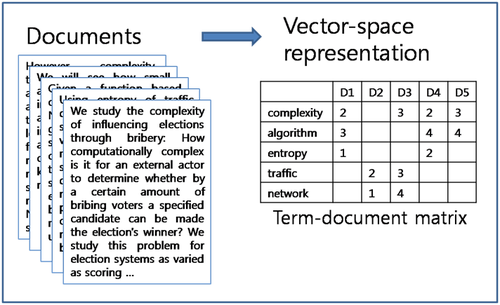

In [16]:
nb_setup.images_hconcat(["NLP_images/tdm.png"], width=500)

## Term Frequency - Inverse Document Frequency (TF-IDF)

This is a weighting scheme provided to sharpen the importance of rare words in a document, relative to the frequency of these words in the corpus. It is based on simple calculations and even though it does not have strong theoretical foundations, it is still very useful in practice. The TF-IDF is the importance of a word $w$ in a document $d$ in a corpus $C$. Therefore it is a function of all these three, i.e., we write it as $TFIDF(w,d,C)$, and is the product of term frequency (TF) and inverse document frequency (IDF).

The frequency of a word in a document is defined as

$$
f(w,d)=\frac{\#w \in d}{|d|}
$$

where $|d|$ is the number of words in the document. We may normalize word frequency so that

$$
TF(w,d)=ln[f(w,d)]
$$

This is log normalization. Another form of normalization is known as double normalization and is as follows:

$$
TF(w,d)=\frac{1}{2} + \frac{1}{2} \cdot \frac{f(w,d)}{\max_{w \in d} f(w,d)}
$$

Note that normalization is not necessary, but it tends to help shrink the difference between counts of words.

Inverse document frequency is as follows (in this case we show the normalized version):

$$
IDF(w,C)=\ln\left[\frac{|C|}{|d_{w \in d}|}\right]
$$

That is, we compute the ratio of the number of documents in the corpus $C$ divided by the number of documents with word $w$ in the corpus.

Finally, we have the weighting score for a given word $w$ in document $d$ in corpus $C$:

$$
TFIDF(w,d,C)=TF(w,d) \times IDF(w,C)
$$

In [17]:
# Collect some text data
# !pip install cssselect
import requests
from lxml.html import fromstring

#Copy the URL from the web site
url = 'https://economictimes.indiatimes.com'
html = requests.get(url, timeout=10).text

#See: http://infohost.nmt.edu/~shipman/soft/pylxml/web/etree-fromstring.html
doc = fromstring(html)      

#http://lxml.de/cssselect.html#the-cssselect-method
doc.cssselect(".active")

x = doc.cssselect(".active li")    #Try a, h2, section if you like
print(x, end = '\n\n') # elements of titles
headlines = [x[j].text_content() for j in range(len(x))]
headlines = headlines[:20]   #Needed to exclude any other stuff that was not needed. 
print(headlines)

[<Element li at 0x2119e596728>, <Element li at 0x2119e55edb8>, <Element li at 0x2119e5c2778>, <Element li at 0x2119e5c2728>, <Element li at 0x2119e5c27c8>, <Element li at 0x2119e5c2818>, <Element li at 0x2119e5c2868>, <Element li at 0x2119e5c28b8>, <Element li at 0x2119e5c2908>, <Element li at 0x2119e5c2958>, <Element li at 0x2119e5c29a8>, <Element li at 0x2119e5c29f8>, <Element li at 0x2119e5c2a48>, <Element li at 0x2119e5c2a98>, <Element li at 0x2119e5c2ae8>, <Element li at 0x2119e5c2b38>, <Element li at 0x2119e5c2b88>, <Element li at 0x2119e5c2bd8>, <Element li at 0x2119e5c2c28>, <Element li at 0x2119e5c2c78>, <Element li at 0x2119e5c2cc8>, <Element li at 0x2119e5c2d18>, <Element li at 0x2119e5c2d68>, <Element li at 0x2119e5c2db8>, <Element li at 0x2119e5c2e08>, <Element li at 0x2119e5c2e58>, <Element li at 0x2119e5c2ea8>, <Element li at 0x2119e5c2ef8>, <Element li at 0x2119e5c2f48>, <Element li at 0x2119e5c2f98>, <Element li at 0x2119e5cb048>]

['TikTok signs deal with Sony Music',

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(headlines) # creates the vocabulary on headlines
tfs = tfidf.fit_transform(headlines) # convertin articles into matrix
tfs

<20x115 sparse matrix of type '<class 'numpy.float64'>'
	with 130 stored elements in Compressed Sparse Row format>

In [19]:
tfs.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.40824829,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### So far this is the dcument term matrix
- Because we have 20 rows and 142 columns

In [20]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

res = [word_tokenize(j) for j in headlines]
res[:2]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Behnam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[['TikTok', 'signs', 'deal', 'with', 'Sony', 'Music'],
 ['View', ':', 'US', 'electoral', 'outcome', '&', 'its', 'implications']]

### We Transpose the previous matrix to create Term-Document matrix

In [21]:
# Make TDM
tdm_mat = tfs.toarray().T
print(tdm_mat.shape)
tdm_mat

(115, 20)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.40824829, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## WordClouds

In [22]:
text = ''
for h in headlines:
    text = text + ' ' + h
print(text)

 TikTok signs deal with Sony Music View: US electoral outcome & its implications IPL: DC beat RCB to grab top-two finish Adani group takes over Lucknow airport RBI pushes current a/c new norms' deadline RCap invites bids for stake sale in subsidiaries Twitter launches ArtHouse in India Govt extends ECLGS till the end of Nov DCGI rejects change of status for remdesivir Bandhan Bank prunes Covid risk projections Hero Electric offers benefits on e-scooters E-way bills for October clocked 64.1 million ICAO to audit DGCA in February next year Dubai’s Logistics Sector Reinventing Itself Airtel better placed than Jio to net VI's users US polls: Will the loser accept the result?  How Trump's vacillations aided Covid's spread Harley-Davidson's dealers in the lurch RIL to start gas output from R-field in Nov


(-0.5, 399.5, 199.5, -0.5)

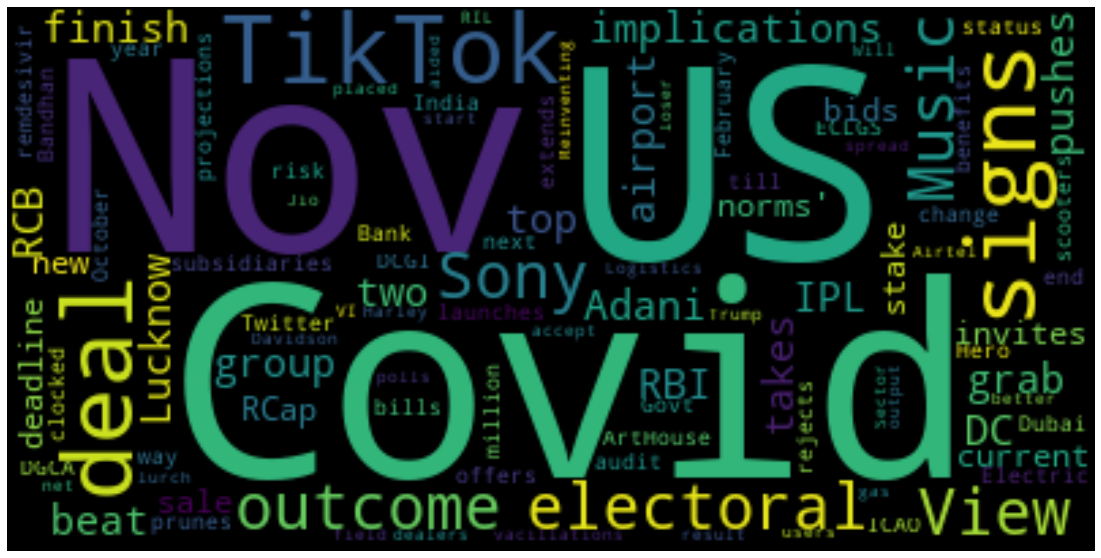

In [23]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(text)

#Use pyplot from matplotlib
figure(figsize=(20,10))
pyplot.imshow(wordcloud, interpolation='bilinear')
pyplot.axis("off")

## Cosine Similarity in the Text Domain

In this segment we will learn some popular functions on text that are used in practice. One of the first things we like to do is to find similar text or like sentences (think of web search as one application). Since documents are vectors in the TDM, we may want to find the closest vectors or compute the distance between vectors.

$$
\cos(\theta) = \frac{A \cdot B}{||A|| \cdot ||B||}
$$
 

where $||A|| = \sqrt{A \cdot A}$, is the dot product of $A$ with itself, also known as the norm of $A$. This gives the cosine of the angle between the two vectors and is zero for orthogonal vectors and 1 for identical vectors.

In [24]:
#COSINE DISTANCE OR SIMILARITY
A = array([0,3,4,1,7,0,1])
B = array([0,4,3,0,6,1,1])
cos = A.dot(B)/(sqrt(A.dot(A)) * sqrt(B.dot(B)))
print('Cosine similarity = ',cos)

#Using sklearn
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([A, B], dense_output=True)

Cosine similarity =  0.9682727993019339


array([[1.       , 0.9682728],
       [0.9682728, 1.       ]])

### As you can see above, the similarity between those 2 vector are too high despite the fact that they are not identical
- In all directions theye are very simillar and only a very small angle between them

### Using Scipy `scipy.spatial.distance.cosine`

\$$
1- \frac{A \cdot B}{||A|| \cdot ||B||}
$$

In [25]:
from scipy import spatial # for cosine distance

1 - spatial.distance.cosine(A, B) 


0.968272799301934

## Minimum Edit Distance

The MED is the minimum number of edits needed to transform one string into another. The strings could be words or sentences or even documents. This is also known as the Levenshtein distance. 

For example, to convert Apple into Amazon, we need to change p->m, p->a, l->z, e->o, add n. This entails 5 simple operations. 

**Properties**:

1. Zero only for identical strings. 
2. Minimum = the difference of the sizes of the two strings.
3. Maximum = length of the longer string.
4. Satisfies the Triangle Inequality: The Levenshtein distance between two strings is no greater than the sum of their Levenshtein distances from a third string.


See the Lazy Prices paper: https://hbswk.hbs.edu/item/lazy-prices, which uses MED for document similarity. Get the published paper through the library for free: https://onlinelibrary.wiley.com/doi/epdf/10.1111/jofi.12885

(Adapted from https://github.com/kristinauko/challenge_100/blob/master/day28.py)

In [26]:
def min_edit_distance(string1, string2):

    if len(string1) > len(string2):
        difference = len(string1) - len(string2)
        string1[:difference]

    elif len(string2) > len(string1):
        difference = len(string2) - len(string1)
        string2[:difference]

    else:
        difference = 0

    for i in range(min(len(string1),len(string2))):
        if string1[i] != string2[i]:
            difference += 1

    return difference

print(min_edit_distance("Amazon", "Apple")) 

5


### Or:


`pip install editdistance`

In [27]:
import editdistance

editdistance.eval("Amazon", "Apple")


5

## Simple Similarity 

(Also in the Lazy Prices paper.)

This measure compares two documents word by word or character by character. It uses an old document $D_1$ and a new document $D_2$ and counts the additions, deletions, and changes of words, normalized by the sum of words in the two documents. 

It is a simple side-by-side comparison method. Much like the function “Track Changes” in Microsoft Word or the function “diff” in Unix/Linux terminal.

In [28]:
import os
import difflib  # https://docs.python.org/2/library/difflib.html
from nltk.tokenize import word_tokenize

D1 = "Some areas around the world that were devastated by the coronavirus in the spring — and are now tightening rules to head off a second wave — are facing resistance from residents who are exhausted, confused and frustrated."
print(D1, "\n")
D1 = word_tokenize(D1)

D2 = "Some parts of the world devastated by the terrible coronavirus in the winter — have now tightened rules to head off a second wave but are facing resistance from residents who are exhausted, bewildered and angry."
print(D2)
D2 = word_tokenize(D2)

print("Length D1: ",len(D1[:3]),D1[:3])
print("Length D2: ",len(D2[:3]),D2[:3])
print("MED =",min_edit_distance(D1[:3],D2[:3])) # on the 1st three tokens
print()

print("Length D1: ",len(D1),D1)
print("Length D2: ",len(D2),D2)
print("MED =",min_edit_distance(D1,D2)) 

Some areas around the world that were devastated by the coronavirus in the spring — and are now tightening rules to head off a second wave — are facing resistance from residents who are exhausted, confused and frustrated. 

Some parts of the world devastated by the terrible coronavirus in the winter — have now tightened rules to head off a second wave but are facing resistance from residents who are exhausted, bewildered and angry.
Length D1:  3 ['Some', 'areas', 'around']
Length D2:  3 ['Some', 'parts', 'of']
MED = 2

Length D1:  40 ['Some', 'areas', 'around', 'the', 'world', 'that', 'were', 'devastated', 'by', 'the', 'coronavirus', 'in', 'the', 'spring', '—', 'and', 'are', 'now', 'tightening', 'rules', 'to', 'head', 'off', 'a', 'second', 'wave', '—', 'are', 'facing', 'resistance', 'from', 'residents', 'who', 'are', 'exhausted', ',', 'confused', 'and', 'frustrated', '.']
Length D2:  38 ['Some', 'parts', 'of', 'the', 'world', 'devastated', 'by', 'the', 'terrible', 'coronavirus', 'in', 

In [29]:
print(len(D1), len(D2))
print(len(set(D1).intersection(set(D2))))
editdistance.eval(D1, D2)

40 38
26


12

In [30]:
res = list(difflib.ndiff(D1,D2))
print("DIFFs =",len(res))
nplus = len([j for j in res if j[0].startswith('+')])
nminus = len([j for j in res if j[0].startswith('-')])
print("SIMPSIM =",nplus,nminus,(nplus+nminus)/(len(D1)+len(D2)))

DIFFs = 49
SIMPSIM = 9 11 0.2564102564102564


## Sentence Similarity via Language Representation

We can determine sentence similarity based on raw text using set-based similarity methods, as we will see later in this notebook. 

However, computing similarity is basically a mathematical operation and requires quantification of text into vectors, matrices, tensors. We have seen an example of such similarity in the computation of cosine similarity above. In that example, we used simple word count vectors. 

However, there are other ways of transforming sentences into fixed-length vectors so that we can compute cosine similarity. These are known as "embeddings", i.e., we convert the text of a sentence into a numeric vector of dimension $n$ which can be thought of as an embedding of that sentence into $n$-dimensional space. 

Two popular ways this is done is using traditional word embeddings such as word2vec and BERT model embeddings. Word2vec creates word embeddings and there is a corresponding package for sentence enbeddings, sent2vec. 

`!py -3.7 -m pip install sent2vec`

In [31]:
from scipy import spatial # for cosine distance
from sent2vec.vectorizer import Vectorizer # uses DistilBERT

sentences = [
    "There are several approaches to learn NLP.",
    "BERT is an amazing NLP language model.",
    "We can use embedding, encoding, or vectorizing to represent language.",
]

vectorizer = Vectorizer() # create an empty vectorizer
vectorizer.bert(sentences) # pass the sentence into the bert neural network
vectors_bert = vectorizer.vectors # vectors_bert is a list of 3 vectors each for oner sentence

print(len(vectors_bert))
print([len(v) for v in vectors_bert])
print(vectors_bert[0]) # the 1st of three vectors

3
[768, 768, 768]
[-2.26823345e-01 -1.47761151e-01 -5.47620654e-03 -3.04903626e-01
 -3.22079241e-01 -1.62703499e-01  2.03431603e-02  1.00655206e-01
  3.73834707e-02 -5.03204346e-01 -1.22439884e-01  1.63336530e-01
  1.29844435e-02  6.99329972e-02  3.26595679e-02  3.87873799e-01
 -7.59130344e-04  2.40361661e-01 -1.91939890e-01 -2.15191185e-01
 -1.55010760e-01 -5.68635538e-02  1.55610532e-01 -8.65275860e-02
  8.88643321e-04 -6.96208924e-02  7.45740086e-02  9.62959900e-02
  2.06479549e-01 -6.76914603e-02 -9.84044150e-02  4.25805062e-01
 -1.33869693e-01 -2.16157794e-01  1.26786172e-01  6.81598037e-02
  3.96859735e-01  1.13229953e-01  4.18778718e-01  3.79229933e-02
 -1.06499687e-01  9.64723155e-02  1.49632946e-01  9.64186043e-02
 -4.75685336e-02 -1.01827770e-01 -2.63574886e+00  1.65035687e-02
 -4.71194208e-01 -4.67932343e-01 -1.86668634e-01  2.94501930e-01
  9.48905498e-02  5.40360391e-01  8.56119394e-03  3.07039380e-01
 -3.35936040e-01  1.45308644e-01  1.37860537e-01  2.19708368e-01
  9.555

### `vectorizer.bert` transforms the sentences to the vectors of 768 elements

In [32]:
dist_1 = spatial.distance.cosine(vectors_bert[0], vectors_bert[1])
print(dist_1)
dist_2 = spatial.distance.cosine(vectors_bert[0], vectors_bert[2])
print(dist_2)
dist_3 = spatial.distance.cosine(vectors_bert[1], vectors_bert[2])
print(dist_3)

0.05770748853683472
0.13797229528427124
0.14963024854660034


### `spatial.distance.cosine` shows `1 - cosine similarity`, to convert it to usual similarity:

In [33]:
print(1-dist_1)
print(1-dist_2)
print(1-dist_3)

0.9422925114631653
0.8620277047157288
0.8503697514533997


In [34]:
vectors_bert[0].shape

(768,)

### Maxpooling
- Getting the average of vetors for all sentences so we have one vector of the length of each sentence representing the whole document

In [35]:
max_pooling_vec = np.zeros( len(vectors_bert[0]) )
for v in vectors_bert:
    max_pooling_vec += v
    
max_pooling_vec = max_pooling_vec / len(vectors_bert)
print(max_pooling_vec.shape)
max_pooling_vec

(768,)


array([-2.86825463e-01, -1.46044783e-01, -1.09986119e-01, -2.81315267e-01,
       -2.95538157e-01, -1.43322927e-01,  8.78203530e-02,  2.54561427e-01,
       -7.22112684e-02, -4.14759556e-01, -8.24322316e-02,  3.56664564e-02,
       -1.10327552e-01,  8.83591622e-02,  6.33031006e-02,  2.55414019e-01,
       -1.76498940e-02,  2.65498946e-01, -1.91192577e-02, -3.39971284e-02,
       -1.87828777e-01, -7.46058592e-02,  2.69104044e-02, -6.81275353e-02,
        7.52795604e-02, -2.13519822e-01,  1.51352825e-01,  4.44784587e-02,
        1.15064457e-01, -4.68088730e-02, -1.32727645e-01,  4.33370968e-01,
       -8.27574208e-02, -3.47988824e-01,  1.02197760e-01, -4.09854973e-02,
        3.58071009e-01,  1.58835923e-02,  2.17307807e-01,  1.89023962e-01,
       -1.17627975e-01,  7.99703946e-02,  1.67717740e-01,  1.18161661e-01,
       -8.55648232e-02, -2.07272510e-01, -2.82199502e+00, -3.95800918e-04,
       -3.03998401e-01, -4.50831393e-01, -2.84365309e-01,  1.31394678e-01,
       -1.99965735e-02,  

## Readability of Text 

Or, how to grade text!

In recent years, the SAT exams added a new essay section. While the test aimed at assessing original writing, it also introduced automated grading. A goal of the test is to assess the writing level of the student. This is associated with the notion of readability.

“Readability” is a metric of how easy it is to comprehend text. Given a goal of efficient markets, regulators want to foster transparency by making sure financial documents that are disseminated to the investing public are readable. Hence, metrics for readability are very important and are recently gaining traction.

## Gunning-Fog Index

Gunning (1952) developed the Fog index. The index estimates the years of formal education needed to understand text on a first reading. A fog index of 12 requires the reading level of a U.S. high school senior (around 18 years old). The index is based on the idea that poor readability is associated with longer sentences and complex words. Complex words are those that have more than two syllables. The formula for the Fog index is

$$
0.4 \left[\frac{\#words}{\#sentences} + 100 \cdot \frac{\#complex words}{\#words} \right]
$$
 

## Flesch Score

Alternative readability scores use similar ideas. The Flesch Reading Ease Score and the Flesch-Kincaid Grade Level also use counts of words, syllables, and sentences. See http://en.wikipedia.org/wiki/Flesch-Kincaid_readability_tests. The Flesch Reading Ease Score is defined as

$$
206.835−1.015 \cdot \frac{\#words}{\#sentences} − 84.6 \cdot \frac{\#syllables}{\#words}
$$ 

With a range of 90-100 easily accessible by a 11-year old, 60-70 being easy to understand for 13-15 year olds, and 0-30 for university graduates.

## The Flesch-Kincaid Grade Level

This is defined as

$$
0.39 \cdot \frac{\#words}{\#sentences} + 11.8 \cdot \frac{\#syllables}{\#words} − 15.59
$$ 

which gives a number that corresponds to the grade level. As expected these two measures are negatively correlated. Various other measures of readability use the same ideas as in the Fog index. For example the Coleman and Liau (1975) index does not even require a count of syllables, as follows:

$$
CLI=0.0588L−0.296S−15.8
$$ 

where $L$ is the average number of letters per hundred words and  $S$  is the average number of sentences per hundred words.

Standard readability metrics may not work well for financial text. Loughran and McDonald (2014) find that the Fog index is inferior to simply looking at 10-K file size.

*References*

- M. Coleman and T. L. Liau. (1975). A computer readability formula designed for machine scoring. Journal of Applied Psychology 60, 283-284.

- T. Loughran and W. McDonald, (2014). Measuring readability in financial disclosures, The Journal of Finance 69, 1643-1671.

`!py -3.7 -m pip install textstat`

In [36]:
test_data = (
    "Playing games has always been thought to be important to "
    "the development of well-balanced and creative children; "
    "however, what part, if any, they should play in the lives "
    "of adults has never been researched that deeply. I believe "
    "that playing games is every bit as important for adults "
    "as for children. Not only is taking time out to play games "
    "with our children and other adults valuable to building "
    "interpersonal relationships but is also a wonderful way "
    "to release built up tension."
)

import textstat

print("number of words:", len(test_data))
print(textstat.flesch_reading_ease(test_data))
print(textstat.flesch_kincaid_grade(test_data))
print(textstat.gunning_fog(test_data))


number of words: 485
52.23
12.8
12.38


### [Click to skip R part](#section_1)

---

## koRpus package

R package koRpus for readability scoring here. http://www.inside-r.org/packages/cran/koRpus/docs/readability

First, let’s grab some text from my web site.

In [36]:
%%R
library(rvest)
url = "http://srdas.github.io/bio-candid.html"

doc.html = read_html(url)
text = doc.html %>% html_nodes("p") %>% html_text()

text = gsub("[\t\n]"," ",text)
text = gsub('"'," ",text)   #removes single backslash
text = paste(text, collapse=" ")
print(text)

UsageError: Cell magic `%%R` not found.


In [ ]:
%%R
# install the language support package for the first time
# conda install -c conda-forge r-korpus.lang.en
#install.koRpus.lang("en")
# load the package
library(koRpus.lang.en)

In [ ]:
%%R
library(koRpus)
write(text,file="textvec.txt")
#text_tokens = tokenize("textvec.txt",tag=FALSE)
text_tokens = tokenize("textvec.txt",lang="en")
print(text_tokens)
print(c("Number of sentences: ",text_tokens@desc$sentences))

In [ ]:
%%R
print(readability(text_tokens))

## Text Summarization

There are two broad types of text summarization:

1. Extractive: provide the most meaningful extracted subsample from the text.
2. Abstractive: generate new language that explains the document more briefly. 

There are some metrics for the quality of summarization, see: http://nlpprogress.com/english/summarization.html

## Jaccard Summarizer

A document $D$  is comprised of  $m$  sentences  $s_i,i=1,2,...,m$, where each  $s_i$  is a set of words. We compute the pairwise overlap between sentences using the Jaccard similarity index:

$$
J_{ij} = J(s_i,s_j)=\frac{|s_i \cap s_j|}{|s_i \cup s_j|} = J_{ji}
$$ 

The overlap is the ratio of the size of the intersect of the two word sets in sentences  $s_i$  and  $s_j$, divided by the size of the union of the two sets. The similarity score of each sentence is computed as the row sums of the Jaccard similarity matrix.

$$
S_i=\sum_{j=1}^m J_{ij}
$$

### Generating the summary

Once the row sums are obtained, they are sorted and the summary is the first  $n$  sentences based on the  $S_i$  values.

In [60]:
%%R
# FUNCTION TO RETURN n SENTENCE SUMMARY
# Input: array of sentences (text)
# Output: n most common intersecting sentences
text_summary = function(text, n) {
  m = length(text)  # No of sentences in input
  jaccard = matrix(0,m,m)  #Store match index
  for (i in 1:m) {
    for (j in i:m) {
      a = text[i]; aa = unlist(strsplit(a," "))
      b = text[j]; bb = unlist(strsplit(b," "))
      jaccard[i,j] = length(intersect(aa,bb))/
                          length(union(aa,bb))
      jaccard[j,i] = jaccard[i,j]
    }
  }
  similarity_score = rowSums(jaccard)
  res = sort(similarity_score, index.return=TRUE,
          decreasing=TRUE)
  idx = res$ix[1:n]
  summary = text[idx]
}

UsageError: Cell magic `%%R` not found.


## One Function to Rule All Text in R

Also, a quick introduction to the tm package in R: https://cran.r-project.org/web/packages/tm/vignettes/tm.pdf

Install: `conda install -c r r-tm`

In [ ]:
%%R
library(tm)
library(stringr)
#READ IN TEXT FOR ANALYSIS, PUT IT IN A CORPUS, OR ARRAY, OR FLAT STRING
#cstem=1, if stemming needed
#cstop=1, if stopwords to be removed
#ccase=1 for lower case, ccase=2 for upper case
#cpunc=1, if punctuation to be removed
#cflat=1 for flat text wanted, cflat=2 if text array, else returns corpus
read_web_page = function(url,cstem=0,cstop=0,ccase=0,cpunc=0,cflat=0) {
    text = readLines(url)
    text = text[setdiff(seq(1,length(text)),grep("<",text))]
    text = text[setdiff(seq(1,length(text)),grep(">",text))]
    text = text[setdiff(seq(1,length(text)),grep("]",text))]
    text = text[setdiff(seq(1,length(text)),grep("}",text))]
    text = text[setdiff(seq(1,length(text)),grep("_",text))]
    text = text[setdiff(seq(1,length(text)),grep("\\/",text))]
    ctext = Corpus(VectorSource(text))
    if (cstem==1) { ctext = tm_map(ctext, stemDocument) }
    if (cstop==1) { ctext = tm_map(ctext, removeWords, stopwords("english"))}
    if (cpunc==1) { ctext = tm_map(ctext, removePunctuation) }
    if (ccase==1) { ctext = tm_map(ctext, tolower) }
    if (ccase==2) { ctext = tm_map(ctext, toupper) }
    text = ctext
    #CONVERT FROM CORPUS IF NEEDED
    if (cflat>0) {
        text = NULL
        for (j in 1:length(ctext)) {
            temp = ctext[[j]]$content
            if (temp!="") { text = c(text,temp) }
        }
        text = as.array(text)
    }
    if (cflat==1) {
        text = paste(text,collapse="\n")
        text = str_replace_all(text, "[\r\n]" , " ")
    }
    result = text
}

## Example: Summarization

We will use a sample of text that I took from Bloomberg news. It is about the need for data scientists.

In [ ]:
%%R
url = "NLP_data/dstext_sample.txt"   #You can put any text file or URL here
text = read_web_page(url,cstem=0,cstop=0,ccase=0,cpunc=0,cflat=1)
print(length(text[[1]]))

In [ ]:
%%R
print(text)

In [ ]:
%%R
text2 = strsplit(text,". ",fixed=TRUE)  #Special handling of the period.
text2 = text2[[1]]
print(text2)

In [ ]:
%%R
res = text_summary(text2,5)
print(res)

---

<a id="section_1"></a>

## Text Summarization with Python

This is a approach that distills a document down to its most important sentences. The idea is very simple. The algorithm simply focuses on the essence of a document. The customer use case is that the quantity of reading is too high and a smaller pithy version would be great to have. 

However, in the absence of an article/document, I have some examples where we download an article using selector gadget, Beautiful Soup, and extract the text of the article. But the summarizer/compressor assumes that the article is clean flat file text.

https://www.dataquest.io/blog/web-scraping-tutorial-python/

Install these if needed:

`!pip install lxml
!pip install cssselect
!pip install nltk`

In [37]:
# Read in the news article from the URL and extract only the title and text of the article.
# Some examples provided below.

import requests
from lxml.html import fromstring
# url = 'https://economictimes.indiatimes.com/news/economy/policy/a-tax-cut-for-you-in-budget-wont-give-india-the-boost-it-needs/articleshow/73476138.cms?utm_source=Colombia&utm_medium=C1&utm_campaign=CTN_ET_hp&utm_content=18'
# url = "https://www.nytimes.com/2019/07/29/business/capital-one-data-breach-hacked.html"
url = "https://www.nytimes.com/2019/04/29/us/politics/trump-lawsuit-deutsche-bank.html"
# url = "https://www.nytimes.com/2015/08/16/technology/inside-amazon-wrestling-big-ideas-in-a-bruising-workplace.html"

In [38]:
html = requests.get(url, timeout=10).text

#See: http://infohost.nmt.edu/~shipman/soft/pylxml/web/etree-fromstring.html
doc = fromstring(html)    

#http://lxml.de/cssselect.html#the-cssselect-method
# doc.cssselect(".Normal")  #economic times
doc.cssselect(".StoryBodyCompanionColumn")   #nytimes

[<Element div at 0x2119e577ef8>,
 <Element div at 0x211affa2c28>,
 <Element div at 0x211affa2a48>]

In [40]:
#economic times
# x = doc.cssselect(".Normal")  
# news = x[0].text_content()
# print(news)

#nytimes
x = doc.cssselect(".StoryBodyCompanionColumn") # a list of 3 elements
news = " ".join([x[j].text_content() for j in range(len(x))]) # put the 3 elements into one big string 

Make sure the text you extracted is in string form. Then convert the article into individual sentences. Put the individual sentences into a list. Use BeautifulSoup for this. 

In [42]:
from bs4 import BeautifulSoup
news = BeautifulSoup(news,'lxml').get_text()
print(news)
type(news)

President Trump, his three eldest children and his private company filed a federal lawsuit on Monday against Deutsche Bank and Capital One, in a bid to prevent the banks from responding to congressional subpoenas.In the suit, filed in federal court in Manhattan, the president and his family members argue that the Democratic House committee leaders who issued the subpoenas engaged in a broad overreach.“This case involves congressional subpoenas that have no legitimate or lawful purpose,” the suit alleges. “The subpoenas were issued to harass President Donald J. Trump, to rummage through every aspect of his personal finances, his businesses and the private information of the president and his family, and to ferret about for any material that might be used to cause him political damage. No grounds exist to establish any purpose other than a political one.”The House’s Intelligence and Financial Services Committees issued subpoenas to Deutsche Bank, a longtime lender to Mr. Trump’s real est

str

In [43]:
import nltk
nltk.download("punkt")
from nltk.tokenize import sent_tokenize   # To get separate sentences

sentences = sent_tokenize(news)
print(len(sentences))
for s in sentences:
    print(s)

13
President Trump, his three eldest children and his private company filed a federal lawsuit on Monday against Deutsche Bank and Capital One, in a bid to prevent the banks from responding to congressional subpoenas.In the suit, filed in federal court in Manhattan, the president and his family members argue that the Democratic House committee leaders who issued the subpoenas engaged in a broad overreach.“This case involves congressional subpoenas that have no legitimate or lawful purpose,” the suit alleges.
“The subpoenas were issued to harass President Donald J. Trump, to rummage through every aspect of his personal finances, his businesses and the private information of the president and his family, and to ferret about for any material that might be used to cause him political damage.
No grounds exist to establish any purpose other than a political one.”The House’s Intelligence and Financial Services Committees issued subpoenas to Deutsche Bank, a longtime lender to Mr. Trump’s real 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Behnam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
# Python Summarizer
import re
from array import array
import numpy as np

# Pass in a list of sentences, returns a n-sentence summary
def text_summarizer(sentences, n_summary):
    n = len(sentences)
    x = [re.split('[ ,.]',j) for j in sentences]
    #jaccsim = np.array(zeros(n*n)).reshape((n,n))
    jaccsim = np.zeros((n, n))
    for i in range(n):
        for j in range(i,n):
            jaccsim[i,j] = len(set(x[i]).intersection(set(x[j])))/len(set(x[i]).union(set(x[j])))
            jaccsim[j,i] = jaccsim[i,j]
    #Summary
    idx = np.argsort(np.sum(jaccsim, axis=0))[::-1][:n_summary]  #reverse sort
    summary = [sentences[j] for j in list(idx)]
    #Anomalies
    idx = np.argsort(np.sum(jaccsim, axis=0))[:n_summary] 
    anomalies = [sentences[j] for j in list(idx)]
    return summary, anomalies

In [45]:
# Get the summary and the anomaly sentences
summary, anomalies = text_summarizer(sentences, int(len(sentences)/4))
"  ".join(summary)

'President Trump, his three eldest children and his private company filed a federal lawsuit on Monday against Deutsche Bank and Capital One, in a bid to prevent the banks from responding to congressional subpoenas.In the suit, filed in federal court in Manhattan, the president and his family members argue that the Democratic House committee leaders who issued the subpoenas engaged in a broad overreach.“This case involves congressional subpoenas that have no legitimate or lawful purpose,” the suit alleges.  On April 22, Mr. Trump filed a suit to prevent Mazars from responding to a subpoena from Representative Elijah E. Cummings of Maryland, the chairman of the House Oversight and Reform Committee.But Deutsche Bank holds one of the biggest troves of documents.Starting in the late 1990s, it was the only mainstream financial institution willing to consistently do business with Mr. Trump.  The bank also was an important lender to Mr. Trump’s son Donald Jr. and to the family of his son-in-la

In [46]:
for a in anomalies:
    print(a)

[Read our investigation of Mr. Trump’s history with Deutsche Bank.
“This lawsuit is not designed to succeed; it is only designed to put off meaningful accountability as long as possible.”The suit appears to be part of an increasingly aggressive counteroffensive by Mr. Trump’s administration and his business empire to thwart attempts by House Democrats to investigate him and his presidency.
In a statement, Marc Mukasey and Patrick Strawbridge, the lawyers who filed the suit, said, “Every citizen should be concerned about this sweeping, lawless invasion of privacy.”In the suit, they argue that a lack of legislative purpose to the subpoenas makes them illegal.“‘Oversight’ and ‘transparency,’ in a vacuum, are not legitimate legislative purposes that can justify subpoenaing a private citizen,” the suit says.


## Modern Methods

- Extractive Summarization vs Abstractive Summarization

- Summarization with pointer networks: https://drive.google.com/file/d/1fAgr85WAQU8OXYkwifuF4Ep-LXfrwinv/view?usp=sharing

- Use Hugging Face Transformers as shown next: https://huggingface.co/transformers/main_classes/pipelines.html

In [47]:
from transformers import pipeline

summarizer = pipeline("summarization")
if len(news)>1024:   # max seq length
  news = news[:1024]   
print(summarizer(news, max_length=int(len(news)/4), min_length=25))

Your max_length is set to 256, but you input_length is only 204. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' President Trump, his three eldest children and his private company file a federal lawsuit against Deutsche Bank and Capital One . The banks are accused of refusing to respond to congressional subpoenas . The suit alleges that the subpoenas were issued to harass the president and his family .'}]


In [48]:
# All in one example for NY Times
url = "https://www.nytimes.com/2015/08/16/technology/inside-amazon-wrestling-big-ideas-in-a-bruising-workplace.html"
html = requests.get(url, timeout=10).text
doc = fromstring(html) 
x = doc.cssselect(".StoryBodyCompanionColumn") 
news = " ".join([x[j].text_content() for j in range(len(x))])
news = BeautifulSoup(news,'lxml').get_text()
print(len(news))
if len(news)>1024:   # max seq length
    news = news[:1024] 
print(summarizer(news, max_length=int(len(news)/4), min_length=25))

Your max_length is set to 256, but you input_length is only 239. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


34845
[{'summary_text': ' At Amazon, workers are encouraged to tear apart one another’s ideas in meetings, toil long and late . Those with perfect scores earn a virtual award proclaiming, “I’m Peculiar” The internal phone directory instructs colleagues on how to send secret feedback to bosses .'}]


Try this additional blog post for more on the T5 (text to text transfer transformer) summarizer. 

https://towardsdatascience.com/simple-abstractive-text-summarization-with-pretrained-t5-text-to-text-transfer-transformer-10f6d602c426

This is a nice web site explaining Hugging Face transformers: https://zenodo.org/record/3733180#.X40RxEJKjlx

And the paper: https://arxiv.org/pdf/1910.10683.pdf

And here is a nice application of the same: https://towardsdatascience.com/summarization-has-gotten-commoditized-thanks-to-bert-9bb73f2d6922

## Long document summarization

This is not feasible unless we break up the text into maximal chunk sizes and do the summary piecemeal. 

In [49]:
url = "https://www.nytimes.com/2015/08/16/technology/inside-amazon-wrestling-big-ideas-in-a-bruising-workplace.html"
html = requests.get(url, timeout=10).text
doc = fromstring(html) 
x = doc.cssselect(".StoryBodyCompanionColumn") 
news = " ".join([x[j].text_content() for j in range(len(x))])
news = BeautifulSoup(news,'lxml').get_text()
print("Size of article =",len(news)," | #Chunks =",int(len(news)/1024))
for j in range(0,len(news),1024):
    print(summarizer(news[j:j+1024], max_length=int(len(news)/4), min_length=25))

Size of article =

Your max_length is set to 8711, but you input_length is only 239. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


 34845  | #Chunks = 34


Your max_length is set to 8711, but you input_length is only 217. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' At Amazon, workers are encouraged to tear apart one another’s ideas in meetings, toil long and late . Those with perfect scores earn a virtual award proclaiming, “I’m Peculiar” The internal phone directory instructs colleagues on how to send secret feedback to bosses .'}]


Your max_length is set to 8711, but you input_length is only 248. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon is conducting a little-known experiment in how far it can push white-collar workers, redrawing the boundaries of what is acceptable . Losers leave or are fired in annual cullings of the staff — “purposeful Darwinism,” one former Amazon human resources director said . Many of the newcomers filing in on Mondays may not be there in a few years .'}]


Your max_length is set to 8711, but you input_length is only 194. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon has designed what many workers call an intricate machine propelling them to achieve Mr. Bezos’ ever-expanding ambitions . “This is a company that strives to do really big, innovative, groundbreaking things,” said Susan Harker, Amazon’s top recruiter .'}]


Your max_length is set to 8711, but you input_length is only 228. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Last month, Amazon eclipsed Walmart as the most valuable retailer in the country . Forbes deemed Mr. Bezos the fifth-wealthiest person on earth .'}]


Your max_length is set to 8711, but you input_length is only 232. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Some say they thrived at Amazon because it pushed them past what they thought were their limits . Others who cycled in and out of the company said what they learned in their brief stints helped their careers .'}]


Your max_length is set to 8711, but you input_length is only 223. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon is in the vanguard of where technology wants to take the modern office . Amazon is more nimble and more productive, but harsher and less forgiving . The company is pushing teams to do more for less money .'}]


Your max_length is set to 8711, but you input_length is only 222. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Bezos was determined almost from the moment he founded Amazon in 1994 to resist the forces he thought sapped businesses over time . He wanted to codify his ideas about the workplace, some of them proudly counterintuitive, into instructions simple enough for a new job .'}]


Your max_length is set to 8711, but you input_length is only 256. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon has rules that are part of its daily language and rituals, used in hiring, cited at meetings and quoted in food-truck lines at lunchtime . The guidelines conjure an empire of elite workers (principle No. 5: “Hire and develop the best”)'}]


Your max_length is set to 8711, but you input_length is only 232. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' The workplace should be infused with transparency and precision about who is really achieving and who is not . Ideal employees are often described as “athletes” with endurance, speed (No. 8: “bias for action”), performance that can be measured and an ability to defy limits . If Amazon becomes like Microsoft, “we would die,” Bezos added .'}]


Your max_length is set to 8711, but you input_length is only 229. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon offers no pretense that catering to employees is a priority . The focus is on relentless striving to please customers, or “customer obsession” (No. 1), with words like “mission” used to describe lightning-quick delivery of Cocoa Krispies or selfie sticks .'}]


Your max_length is set to 8711, but you input_length is only 223. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazonians are instructed to ‘disagree and commit” (No. 13) — to rip into colleagues’ ideas, with feedback that can be blunt to the point of painful . “My main job today: I work hard at helping to maintain the culture,” Bezos said last year at a conference run by Business Insider .'}]


Your max_length is set to 8711, but you input_length is only 231. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Employees often say their co-workers are the sharpest, most committed colleagues they have ever met . Even relatively junior employees can make major contributions .'}]


Your max_length is set to 8711, but you input_length is only 208. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon employees often say the genius of Amazon is the way it drives them to drive themselves . “If you’re a good Amazonian, you become an Amabot,” said one employee .'}]


Your max_length is set to 8711, but you input_length is only 205. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon uses a self-reinforcing set of management, data and psychological tools to spur its white-collar employees to do more and more . “The company is running a continual performance improvement algorithm on its staff,” says former Kindle marketer Amy Michaels .'}]


Your max_length is set to 8711, but you input_length is only 222. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Some veterans interviewed said they were protected from pressures by nurturing bosses or working in relatively slow divisions . Others said the culture stoked their willingness to erode work-life boundaries .'}]


Your max_length is set to 8711, but you input_length is only 214. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' One ex-employee’s fiancé would drive to the Amazon campus at 10 p.m. and dial her cellphone until she agreed to come home . “These businesses were my babies, and I did whatever I could to make them successful” She once used her own money to pay a freelancer in India to enter data .'}]


Your max_length is set to 8711, but you input_length is only 251. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon employees are held accountable for a staggering array of metrics, a process that unfolds in what can be anxiety-provoking sessions called business reviews . A day or two before the meetings, employees receive printouts, sometimes up to 50 or 60 pages long, several workers said .'}]


Your max_length is set to 8711, but you input_length is only 232. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' The meetings crowd out other work, many workers complain, but they say the meetings force them to absorb the metrics of their business . The toughest questions are often about getting to the bottom of “cold pricklies,” or email notifications that inform shoppers that their goods won’t arrive when promised .'}]


Your max_length is set to 8711, but you input_length is only 232. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' A former Army captain who served in Iraq joined Amazon to manage housewares vendors in 2013 . After she had a child, she arranged with her boss to be in the office from 7 a.m.'}]


Your max_length is set to 8711, but you input_length is only 211. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Anytime Feedback Tool allows employees to send praise or criticism about colleagues to management . Bosses know who sends the comments, but their identities are not typically shared with the subjects of the remarks . Amazon spokesman says the tool is just another way to provide feedback .'}]


Your max_length is set to 8711, but you input_length is only 218. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon employees described making quiet pacts with colleagues to bury the same person at once or praise one another lavishly . Others described feeling sabotaged by negative comments from unidentified colleagues with whom they could not argue .'}]


Your max_length is set to 8711, but you input_length is only 206. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Resources are sometimes hoarded . Promising job candidates are especially precious at a company with a high number of open positions . Ideas are critiqued so harshly that some workers fear speaking up .'}]


Your max_length is set to 8711, but you input_length is only 258. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Each year, the internal competition culminates at an extended semi-open tournament called an Organization Level Review . In recent years, other large companies, including Microsoft, General Electric have dropped the practice .'}]


Your max_length is set to 8711, but you input_length is only 210. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon is armed with paper trails to defend the wrongfully accused and incriminate members of competing groups . Or they adopt a strategy of choosing sacrificial lambs to protect more essential players . Dick Finnegan, a consultant who advises companies on how to retain employees, warns of the costs .'}]


Your max_length is set to 8711, but you input_length is only 235. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Several former high-level female executives said they believed that some of the leadership principles worked to their disadvantage . They said they could lose out in promotions because of intangible criteria like ‘earn trust” (principle No. 10)'}]


Your max_length is set to 8711, but you input_length is only 243. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' When she traveled to care for her father, who was suffering from cancer, her status changed . She was blocked from transferring to a less pressure-filled job, she said, and her boss told her she was “a problem”'}]


Your max_length is set to 8711, but you input_length is only 244. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' A woman who had breast cancer was told that she was put on a “performance improvement plan” because “difficulties” in her “personal life” had interfered with fulfilling her work goals . A former human resources executive said she was required to put a woman who recently returned after undergoing serious surgery, and another who had just had a stillborn child, on performance improvement plans .'}]


Your max_length is set to 8711, but you input_length is only 239. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' The top recruiter was available to describe the leadership team’s strong support over the last two years as her husband battled a rare cancer . A spokesman for Amazon said such responses to employees’ crises were “not our policy or practice”'}]


Your max_length is set to 8711, but you input_length is only 226. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon retains new workers in part by requiring them to repay a part of their signing bonus if they leave within a year, and a portion of their hefty relocation fees . “It’s as if you’ve got the C.E. of the company in bed with you at 3 a.m. breathing down your neck.”'}]


Your max_length is set to 8711, but you input_length is only 217. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Several fathers said they left or were considering quitting because of pressure from bosses or peers to spend less time with their families . Amazon insists its reputation for high attrition is misleading .'}]


Your max_length is set to 8711, but you input_length is only 226. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Employees, human resources executives and recruiters describe a steady exodus . Turnover is consistent with others in the technology industry, they said, but declined to disclose data .'}]


Your max_length is set to 8711, but you input_length is only 215. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Amazon is constantly hiring employees, driving them and cutting them, recruiters say . The derisive local nickname for Amazon employees is ‘Amholes” — pugnacious and work-obsessed . Recruiters say other businesses are sometimes cautious about bringing in Amazon workers .'}]


KeyboardInterrupt: 